<h1><center><font color='blue'>ML 2, 2020, By Prof. Dr Jan Nagler </font></center></h1>

## Solutions to Assignment 2 and 3. 
#### Submitted By: Shaikh Muhammad Asjad Raza

## Assignment 1

In [ ]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, cross_val_score, validation_curve
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.scorer import SCORERS
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.random_projection import SparseRandomProjection
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
#plt.rcParams['figure.figsize'] = (10,10)

In [ ]:
#Load dataset
cancer = datasets.load_breast_cancer()

# Convert to df
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
y = cancer.target

In [ ]:
#df.head(5)

In [ ]:
# Normalize the data
sc = StandardScaler()
df = sc.fit_transform(df)
df = pd.DataFrame(df, columns =cancer.feature_names)

#### Side Note: I attended an online lecture of  Mr. Andrew Ng regarding SVMs. According to him Support Vector Machine with Polynomial Kernal require strictly non-negatvie training samples to work best. I am not sure if this correct, otherwise i would have used Min Max Normalization with range between [0, 1].

### Define F2-Scorer

In [ ]:
def f2_scorer(y_true, y_pred):
    y_true, y_pred, = np.array(y_true), np.array(y_pred)
    return fbeta_score(y_true, y_pred, beta=2, pos_label=0, average='binary')
  
#f2 = make_scorer(f2_scorer, greater_is_better=True)

# Analysing the correlation among features 


In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

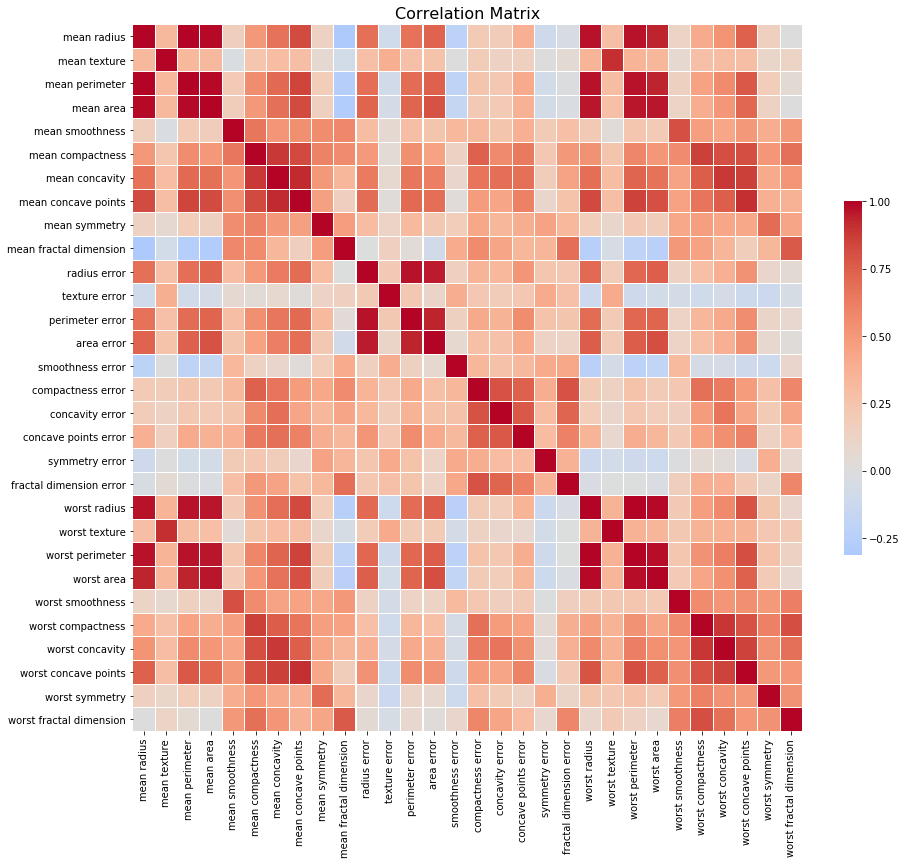

In [ ]:
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(15, 13))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap='coolwarm', vmax=1, center=0, linewidths=0.1, cbar_kws={"shrink": 0.5})
plt.title('Correlation Matrix', fontsize=16);
#sns.heatmap(corr,cmap='coolwarm',annot=True)

#### It can be seen that some of the features are highly coorealated 

# Applying PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
newdata = pca.fit_transform(df)
principalDf = pd.DataFrame(data = newdata)

[44.27 63.24 72.63 79.23 84.73 88.75 91.   92.59 93.98 95.15]


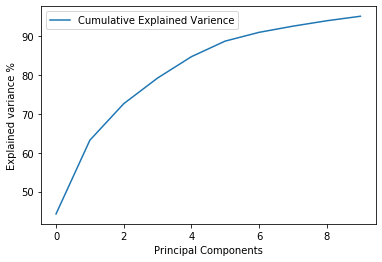

In [ ]:
var = pca.explained_variance_ratio_
cum_var = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
print(cum_var)
import matplotlib.pyplot as plt
plt.plot(cum_var, label='Cumulative Explained Varience')
plt.ylabel('Explained variance %')
plt.xlabel('Principal Components')
plt.legend(loc='best')
plt.show()

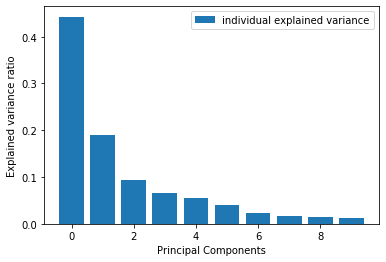

In [ ]:
plt.bar(principalDf.columns,var, label='individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal Components')
plt.legend(loc='best')
plt.show()

### As discussed in the lecture, EVR is showing an elbow at PC=3, Its quite tempting to go with 3 PCs.  But i'll will proceed without PCA applied data because this was not asked to do in Assignment 2.

In [ ]:
pca = PCA(n_components=7)
newdata = pca.fit_transform(df)
principalDf = pd.DataFrame(data = newdata)

### Splitting into train and test set

In [ ]:
# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(df,y, test_size=0.3, random_state=330)

# Grids and Scorers

In [ ]:
param_grid_poly = {'C': [50, 20, 10, 5, 4, 3, 2, 0.1, 0.01, 0.001], 
                   'degree': [2, 4, 6, 10, 22]}


param_grid_rbf = {'C': [0.001, 1.1, 1, 0.1, 2, 3, 4, 30],
                  'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]}
    


scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'f1_score': make_scorer(f1_score),
    'f2_score': make_scorer(f2_scorer, greater_is_better=True)
}

In [ ]:
def parameter_grid(param_grid, scorers, X_train, y_train, cv, refit, model):
    CV_svm_model= GridSearchCV(estimator=model,
                               param_grid=param_grid,
                               scoring=scorers,
                               n_jobs=-1,
                               refit=refit,
                               cv=cv,
                               return_train_score=True)
    
    CV_svm_model = CV_svm_model.fit(X_train, y_train)
    return  CV_svm_model

# SVM with Ploynomial Kernal

In [ ]:
svm_clf = svm.SVC(class_weight='balanced', kernel='poly')
CV_svm_poly = parameter_grid(param_grid_poly, scorers, X_train, y_train, cv = 5, refit='f2_score', model=svm_clf)

In [ ]:
poly_results = pd.DataFrame(CV_svm_poly.cv_results_)

In [ ]:
results =pd.DataFrame(data = poly_results[['param_C', 
                                'param_degree',
                                'mean_test_f2_score',
                                'mean_test_f1_score',
                                'mean_test_recall_score',
                                'mean_test_precision_score']])

### 3D Plot Doesnt look nice

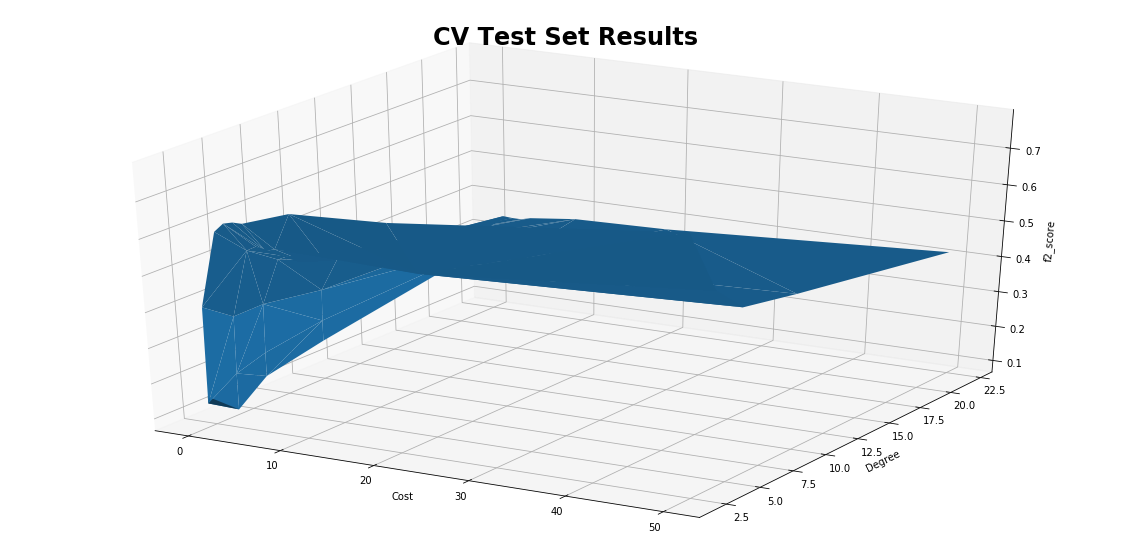

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig =plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
plt.title('CV Test Set Results',fontsize=24, fontweight='bold')

x = results['param_C']
y = results['param_degree']
z = results['mean_test_f2_score']
ax.plot_trisurf(x, y, z, linewidth=0.2, antialiased=True)
ax.set_xlabel('Cost')
ax.set_ylabel('Degree')
ax.set_zlabel('f2_score')

plt.show()

### Ploting Grid Search CV Results

In [ ]:
import seaborn as sns

def plot_cv_results(cv_results, param_x, param_z, metric, t):
    """
    cv_results - cv_results_ attribute of a GridSearchCV instance (or similar)
    param_x - name of grid search parameter to plot on x axis
    param_z - name of grid search parameter to plot by line color
    """
    #cv_results = pd.DataFrame(cv_results)
    col_x = 'param_' + param_x
    col_z = 'param_' + param_z
    title_1 = t
    fig, ax = plt.subplots(figsize=(11, 8))
    sns.pointplot(x=col_x, y=metric, hue=col_z, data=cv_results, dodge=True, ax=ax)
    ax.set_title("CV Grid Search Results for: "+str(title_1))
    ax.set_xlabel(param_x)
    ax.set_ylabel(metric)
    ax.set(ylim=(0, 1.1))
    ax.legend(title=param_z)

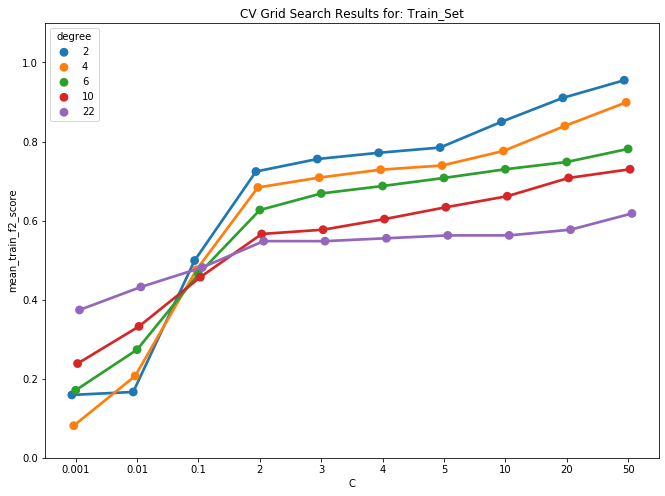

In [ ]:
plot_cv_results(CV_svm_poly.cv_results_,'C','degree', metric='mean_train_f2_score', t='Train_Set')

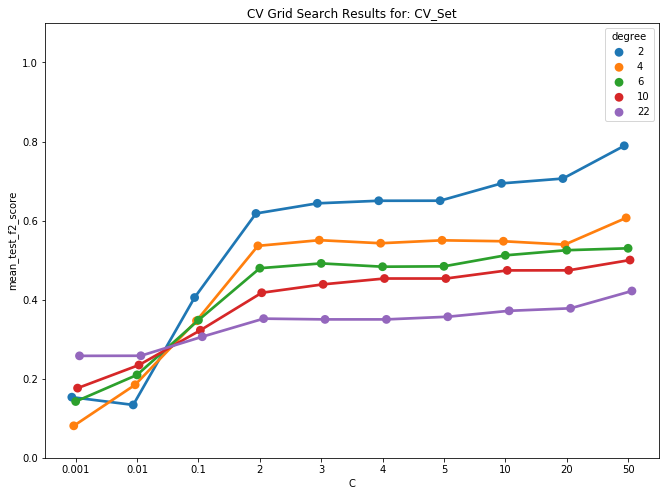

In [ ]:
plot_cv_results(CV_svm_poly.cv_results_,'C','degree', metric='mean_test_f2_score', t='CV_Set')

#### We can see which combination of parameters are optimal/worse for our SVM(Polynomial Kernal), based on CV Results. We can also see the effects of Overfitting and Underfitting . 

### Analysing Degree Parameter based on Optimal C.

In [ ]:
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_f2_score']
    stds_test = results['std_test_f2_score']
    means_train = results['mean_train_f2_score']
    stds_train = results['std_train_f2_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,2,sharex='none', sharey='all',figsize=(20,8))
    fig.suptitle('Score wrt. Parameters on Grid Search CV', fontsize=20, fontweight='bold')
    fig.text(0.004, 0.5, 'MEAN F2 SCORE', va='center', rotation='vertical',fontsize=14, fontweight='bold')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        if i == 2: # we only need gamma and C hyperparamenters
            break
        m = np.stack(masks[:i] + masks[i+1:])
        #pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_2, e_2, linestyle='-.',uplims=True, lolims=True, marker='x', label='Train F2_Score')
        ax[i].errorbar(x, y_1, e_1, linestyle='-.',uplims=True, lolims=True, marker='o', label='Test F2_Score')
        ax[i].set_xlabel(p.upper(), fontsize=20, fontweight='bold')
    plt.legend(prop={'size': 15})
    plt.grid()
    plt.show()

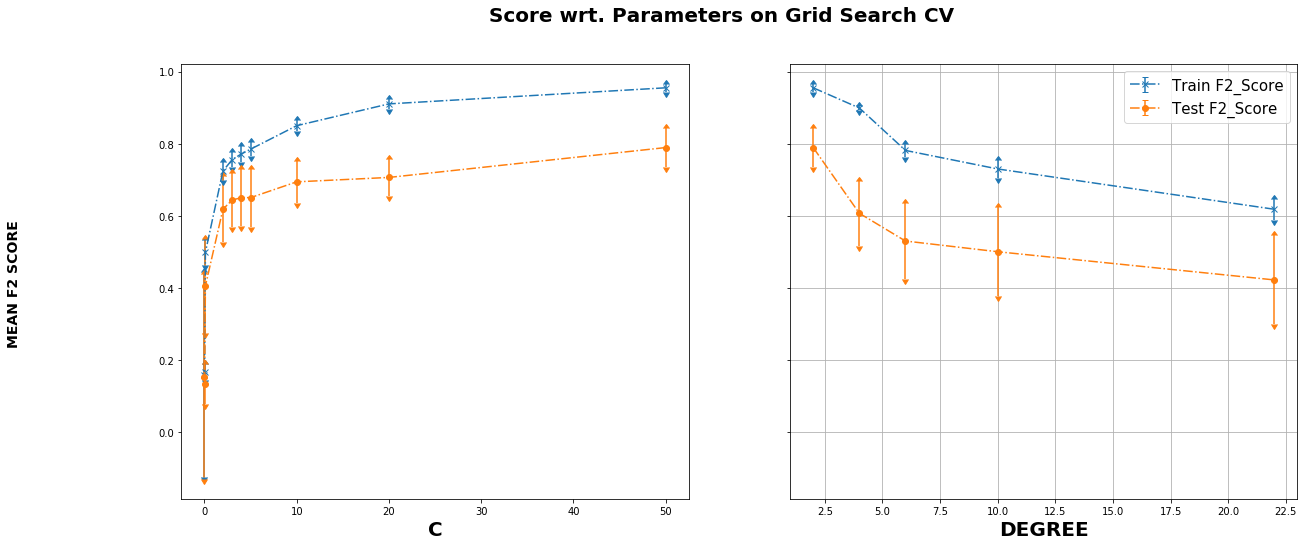

In [ ]:
plot_search_results(CV_svm_poly)

###  F2_score is increasing with increasing C, if we choose c = 50 as optimal and plot F2_score wrt. Degrees, we can see that Degree =2 is giving optimal results. Error bars represents the standard deviation of F2_score from mean on CV 5 fold set.

In [ ]:
print(CV_svm_poly.best_params_) # best parameters

{'C': 50, 'degree': 2}


In [ ]:
svm_clf = svm_clf.set_params(**CV_svm_poly.best_params_)
svm_clf.fit(X_train, y_train)

SVC(C=50, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma='auto_deprecated',
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [ ]:
Y_test_pred = svm_clf.predict(X_test)

### Finally evaluating the best parameters on Test Data

In [ ]:
test_set_score = f2_scorer(y_test, Y_test_pred) # F2_Score on Test Data
print("F2 Score on Test Data: %.3f" % test_set_score)

F2 Score on Test Data: 0.795


Confusion matrix, without normalization
[[59 17]
 [ 8 87]]


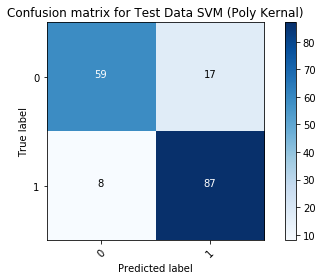

In [ ]:
cmte = confusion_matrix(y_test, Y_test_pred)
np.set_printoptions(precision=2)
class_names = ['0', '1']
plt.figure()
plot_confusion_matrix(cmte, classes=class_names, title='Confusion matrix for Test Data SVM (Poly Kernal)')

# SVM with RFB Kernal

In [ ]:
svm_clf = svm.SVC(class_weight='balanced')
CV_svm_rbf = parameter_grid(param_grid_rbf, scorers, X_train, y_train, cv =5, refit='f2_score', model=svm_clf)

In [ ]:
rbf_results = pd.DataFrame(CV_svm_rbf.cv_results_)

In [ ]:
results =pd.DataFrame(data = rbf_results[['param_C',
                                          'param_gamma',
                                          'mean_test_f1_score',
                                          'mean_test_recall_score',
                                          'mean_test_precision_score',
                                          'mean_test_f2_score']])

### 3D Plot Doesnt look nice

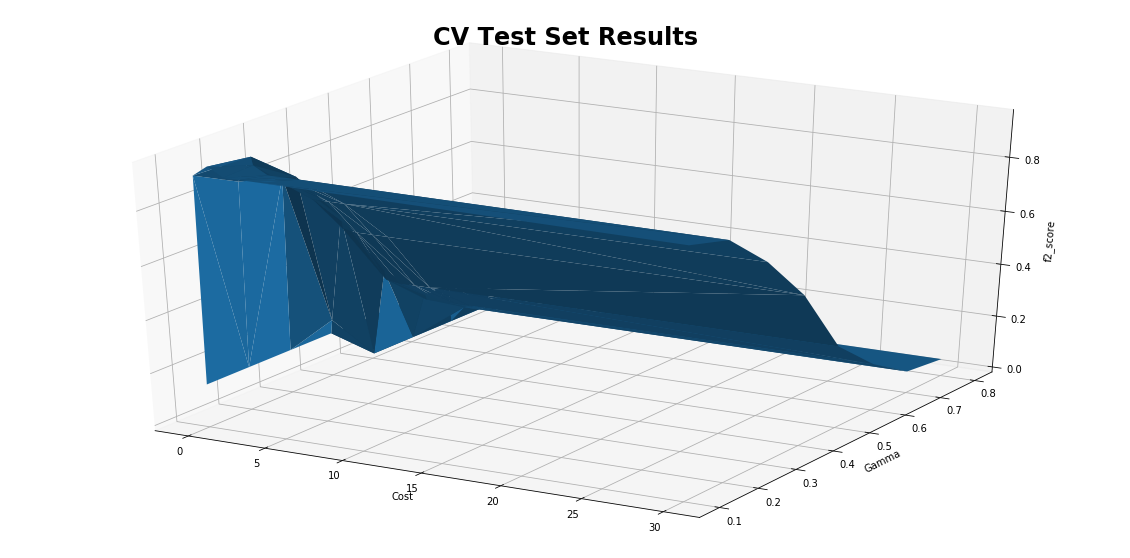

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
plt.title('CV Test Set Results',fontsize=24, fontweight='bold')
x = rbf_results['param_C']
y = rbf_results['param_gamma']
z = rbf_results['mean_test_f2_score']
ax.plot_trisurf(x, y, z, linewidth=0.2, antialiased=True)
ax.set_xlabel('Cost')
ax.set_ylabel('Gamma')
ax.set_zlabel('f2_score')
plt.show()

### Plotting Grid Search CV Results

In [ ]:
def plot_cv_results(cv_results, param_x, param_z, metric, t):
    """
    cv_results - cv_results_ attribute of a GridSearchCV instance (or similar)
    param_x - name of grid search parameter to plot on x axis
    param_z - name of grid search parameter to plot by line color
    """
    #cv_results = pd.DataFrame(cv_results)
    col_x = 'param_' + param_x
    col_z = 'param_' + param_z
    title_1 = t
    fig, ax = plt.subplots(figsize=(11, 8))
    sns.pointplot(x=col_x, y=metric, hue=col_z, data=cv_results, dodge=True, ax=ax)
    ax.set_title("CV Grid Search Results for: "+str(title_1))
    ax.set_xlabel(param_x)
    ax.set_ylabel(metric)
    ax.set(ylim=(0, 1.1))
    ax.legend(title=param_z)
    plt.show

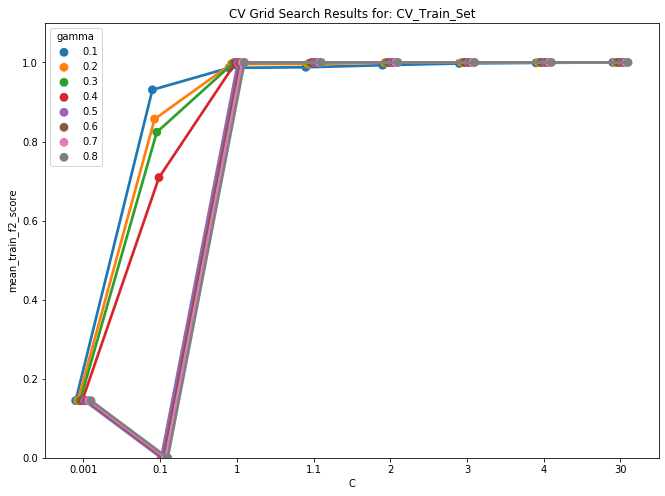

In [ ]:
plot_cv_results(CV_svm_rbf.cv_results_,'C','gamma', metric='mean_train_f2_score', t='CV_Train_Set')

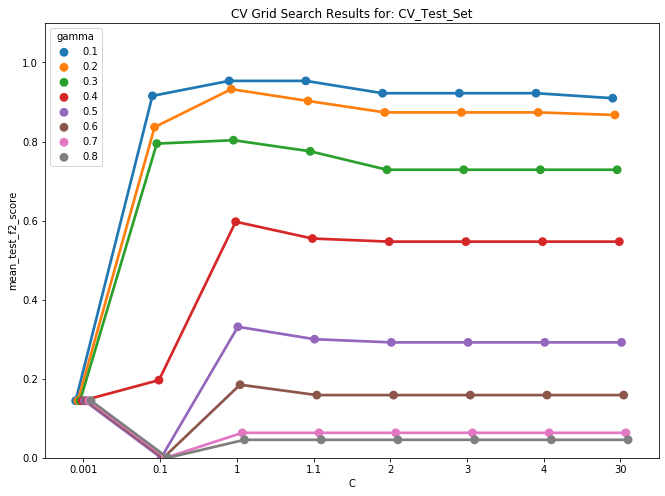

In [ ]:
plot_cv_results(CV_svm_rbf.cv_results_,'C','gamma', metric='mean_test_f2_score', t='CV_Test_Set', )

#### We can see which combination of parameters are optimal/worse for our SVM(RBF Kernal), based on CV results. We can aslo see the effects of Overfitting and Underfitting.

### Analysing Gamma based on Optimal C. 

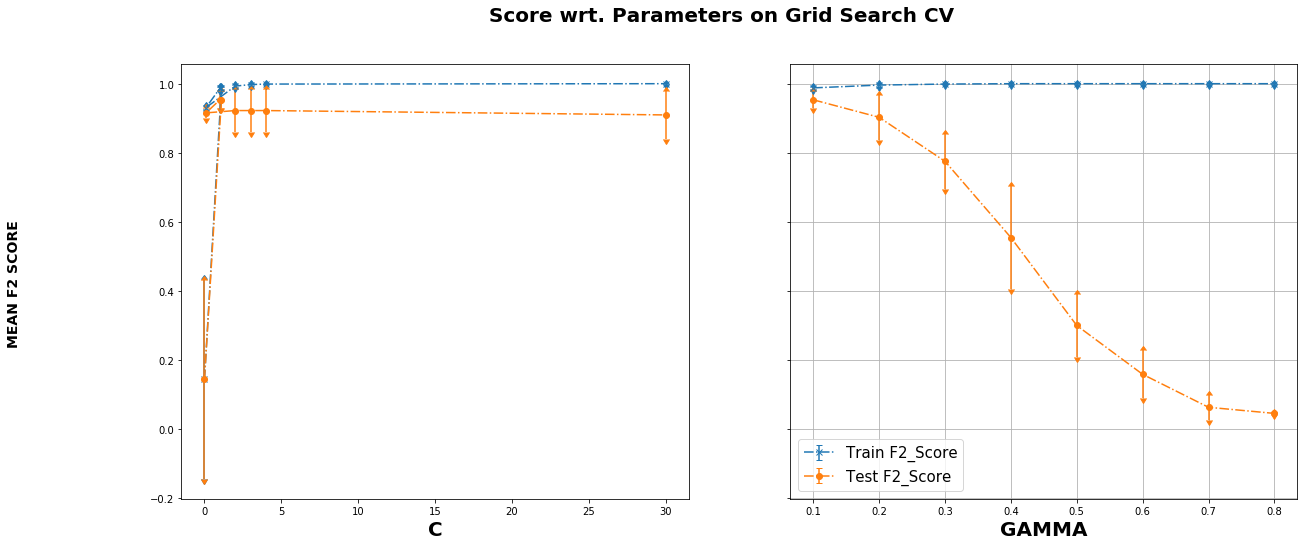

In [ ]:
plot_search_results(CV_svm_rbf)

### C = 1.1 is optimal, keeping it fixed, and varying Gamma gives highest F2_Score at Gamma = 0.1. Error bars show the standard deviation of F2_score from mean on CV 5 fold set.

In [ ]:
print(CV_svm_rbf.best_params_)

{'C': 1.1, 'gamma': 0.1}


In [ ]:
svm_clf = svm_clf.set_params(**CV_svm_rbf.best_params_)
svm_clf.fit(X_train, y_train)

SVC(C=1.1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
Y_test_pred = svm_clf.predict(X_test)

In [ ]:
test_set_score = f2_scorer(y_test, Y_test_pred) #F2_Score
print("F2 Score on Test Data: %.3f" % test_set_score)

F2 Score on Test Data: 0.968


Confusion matrix, without normalization
[[73  3]
 [ 0 95]]


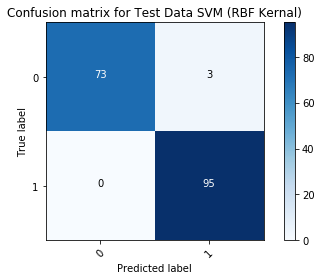

In [ ]:
cmte = confusion_matrix(y_test, Y_test_pred)
np.set_printoptions(precision=2)
class_names = ['0', '1']
plt.figure()
plot_confusion_matrix(cmte, classes=class_names, title='Confusion matrix for Test Data SVM (RBF Kernal)')

In [ ]:
from sklearn.metrics import f1_score
test_set_score = f1_score(y_test, Y_test_pred) #F1_score
print("F1 Score on Test Data: %.3f" % test_set_score)

F1 Score on Test Data: 0.984


## Verdict: Clearly SVM with RBF Kernal wins over SVM with Polynomial Kernal based on F2_Score. 